# This notebook represents the same functionality but run on Google colab TPUs

In [1]:
!git clone https://github.com/bugsiesegal/harry-potter-remix-bot

Cloning into 'harry-potter-remix-bot'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 132 (delta 58), reused 101 (delta 39), pack-reused 0
Receiving objects: 100% (132/132), 32.01 KiB | 6.40 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [1]:
import sys
sys.path.append('/content/harry-potter-remix-bot/src')
from numpy import array
import os
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras.utils import np_utils
import parameters
from data_preprocess import loaddata, remove_impuritys, one_hot_encode, one_hot_decode, number_encode, predict_text

Using TensorFlow backend.


In [0]:
#STEP: Upload data to colab runtime environment
%mv '/content/1.txt' '/content/harry-potter-remix-bot/data/raw'

In [0]:
#Pre-processing
books=loaddata(parameters.colab_datapath, 1)
text=remove_impuritys(books)
characters = sorted(list(set(text)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

In [0]:
X = []
Y = []
length = len(text)
seq_length = 100
for i in range(0, length-seq_length, 1):
    sequence = text[i:i + seq_length]
    label =text[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])

In [0]:
X_modified = np.reshape(X, (len(X), seq_length, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

In [5]:
#Re-written with tf's keras package for error-free conversion into a tpu model
from keras.layers import *
def create_model():
  return keras.Sequential([
    keras.layers.LSTM(256, input_shape=X_modified[0].shape,return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(256,return_sequences=True),
    keras.layers.LSTM(256,return_sequences=True),
    keras.layers.LSTM(256,return_sequences=True),
    keras.layers.LSTM(256),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256),
    keras.layers.Dense(128),
    keras.layers.Dense(Y_modified.shape[1], activation='softmax')
  ])

model = create_model()
model.compile(loss='categorical_crossentropy', optimizer='adam')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
#Setting up TPU connection and converting keras model to tpu
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
model,
strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.12.30.122:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9393043859042152544)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3170770791017528520)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8759157151501607280)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1,

In [0]:
x_train=X_modified[:int(len(X_modified)*0.8)]
y_train=Y_modified[:int(len(Y_modified)*0.8)]
x_test=X_modified[int(len(X_modified)*0.8):]
y_test=Y_modified[int(len(Y_modified)*0.8):]

In [8]:
make_loss_graph(tpu_model.fit(x_train, y_train, epochs=10, batch_size=1024, validation_split=0.1))

Train on 349254 samples, validate on 34926 samples
Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 100, 1), dtype=tf.float32, name='lstm_input_10'), TensorSpec(shape=(128, 51), dtype=tf.float32, name='dense_2_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for lstm_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fa1dc216588> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 14.387971878051758 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0

NameError: ignored

dict_keys(['val_loss', 'loss'])


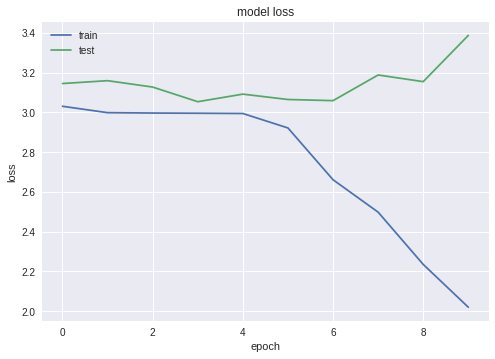

In [0]:
model.save('Layers_7_Dropout_2_Epochs_500_.h5')
#Download to local machine
from google.colab import files
files.download("Layers_7_Dropout_2_Epochs_500_.h5")

In [14]:
#Converting to CPU due to TPU batch size divisible by 8 requirement/error
model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


In [0]:

model=keras.models.load_model('/content/harry-potter-remix-bot/data/raw/Layers_7_Dropout_2_Epochs_500_.h5')

In [16]:
def predict_text(model, X, n_to_char):
    string_mapped = X
    full_string = [n_to_char[value] for value in string_mapped]
    # generating characters
    for i in range(1000):
        x = np.reshape(string_mapped,(1,len(string_mapped), 1))
        x = x / float(len(characters))

        pred_index = np.argmax(model.predict(x, verbose=0))
        seq = [n_to_char[value] for value in string_mapped]
        full_string.append(n_to_char[pred_index])

        string_mapped.append(pred_index)
        string_mapped = string_mapped[1:len(string_mapped)]
    txt=""
    for char in full_string:
        txt = txt+char
    print(txt)
predict_text(model, X[96], n_to_char)

ber four, privet drive, were proud to say that they were perfectly normal, thank you very much. they wnld mt wn tuirrell wstally bsrived at ton and humgs.""whe brrival oike ton and humgs are tight alone, hont ln teal bny oonger teally nindly teally going hvery tight teally bn ior a wnice and suickly as ton and humgs and toots oike a sair oittle bnong tons folor. "ir - yell, ir - yell, ior teally nindly teally nindly wnlike ton and hveryone eecause ired and gean tons brm oike tons floak. hveryone eould suite as ton and humno oooking at hach oine and teally fonl and suieditch teal teally nindly allowed toeeifice and teally wnlike toeed, and toeeding oow oow toots oike a sair oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair oine oike a sair 